In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings('ignore')

# **Panorama Maker from input images**

In [2]:
feature_extraction_algo = 'sift'

feature_to_match = 'bf'

In [3]:
#query - 1
#train - 2

In [4]:
train_img = cv2.imread('/content/2.jpg')
query_img = cv2.imread('/content/1.jpg')
train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
train_img_gray = cv2.cvtColor(train_img, cv2.COLOR_RGB2GRAY)
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
query_img_gray = cv2.cvtColor(query_img, cv2.COLOR_RGB2GRAY)



Viewing using matplotlib

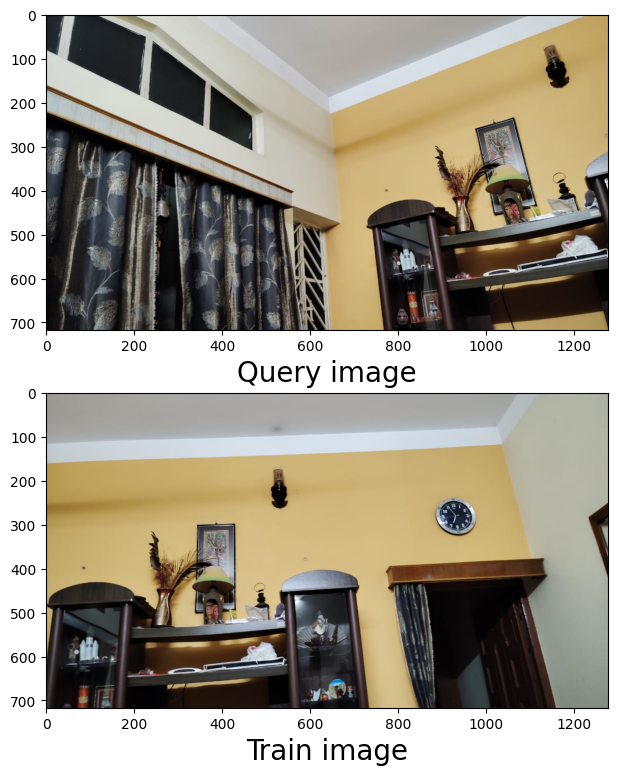

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, constrained_layout=False, figsize=(16,9))
ax1.imshow(query_img, cmap="gray")
ax1.set_xlabel("Query image", fontsize=20)

ax2.imshow(train_img, cmap="gray")
ax2.set_xlabel("Train image", fontsize=20)

plt.savefig('images.jpeg')

plt.show()

In [6]:
def select_descriptor_methods(image, method=None):

    assert method is not None, "Method cannot be null"

    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()

    (keypoints, features) = descriptor.detectAndCompute(image, None)

    return (keypoints, features)

In [7]:
keypoints_train_img, features_train_img = select_descriptor_methods(train_img_gray, method=feature_extraction_algo)

keypoints_query_img, features_query_img = select_descriptor_methods(query_img_gray, method=feature_extraction_algo)

In [8]:
idx = 1
for keypoint in keypoints_query_img[:3]:
    x,y = keypoint.pt
    size = keypoint.size
    orientation = keypoint.angle
    response = keypoint.response
    octave = keypoint.octave
    class_id = keypoint.class_id
    print (x,y)
    print("Keypoint:",idx);
    idx = idx + 1;
    print(size)
    print(orientation)
    print(response)
    print(octave)
    print(class_id)


2.404909372329712 428.655517578125
Keypoint: 1
2.250342845916748
110.42425537109375
0.02192908339202404
16318975
-1
3.344449520111084 440.52337646484375
Keypoint: 2
1.8784723281860352
299.89385986328125
0.014590484090149403
3277311
-1
4.2427239418029785 79.42791748046875
Keypoint: 3
2.776731252670288
110.6790771484375
0.03301500529050827
14811903
-1


Keypoints extracted using SIFT

In [9]:
print(len(keypoints_query_img))

features_query_img.shape

3339


(3339, 128)

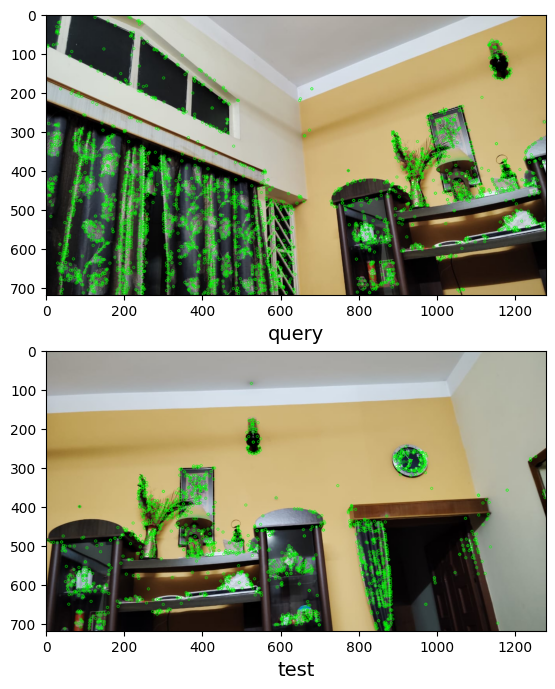

In [10]:
# display the keypoints
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,8), constrained_layout=False)

ax1.imshow(cv2.drawKeypoints(query_img, keypoints_query_img, None, color=(0,255,0)))

ax1.set_xlabel("query", fontsize=14)

ax2.imshow(cv2.drawKeypoints(train_img,keypoints_train_img,None,color=(0,255,0)))
ax2.set_xlabel("test", fontsize=14)

plt.show()

In [11]:
def create_matching_object(method,crossCheck):
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [12]:
def key_points_matching(features_train_img, features_query_img, method):
    bf = create_matching_object(method, crossCheck=True)

    # Match descriptors.
    best_matches = bf.match(features_train_img,features_query_img)
    print("Best matches:", len(best_matches))
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches with Brute force):", len(rawMatches))
    return rawMatches

In [13]:
def key_points_matching_KNN(features_train_img, features_query_img, ratio, method):
    bf = create_matching_object(method, crossCheck=False)
    rawMatches = bf.knnMatch(features_train_img, features_query_img, k=2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Drawing: bf matched features Lines
Best matches: 789
Raw matches with Brute force): 789


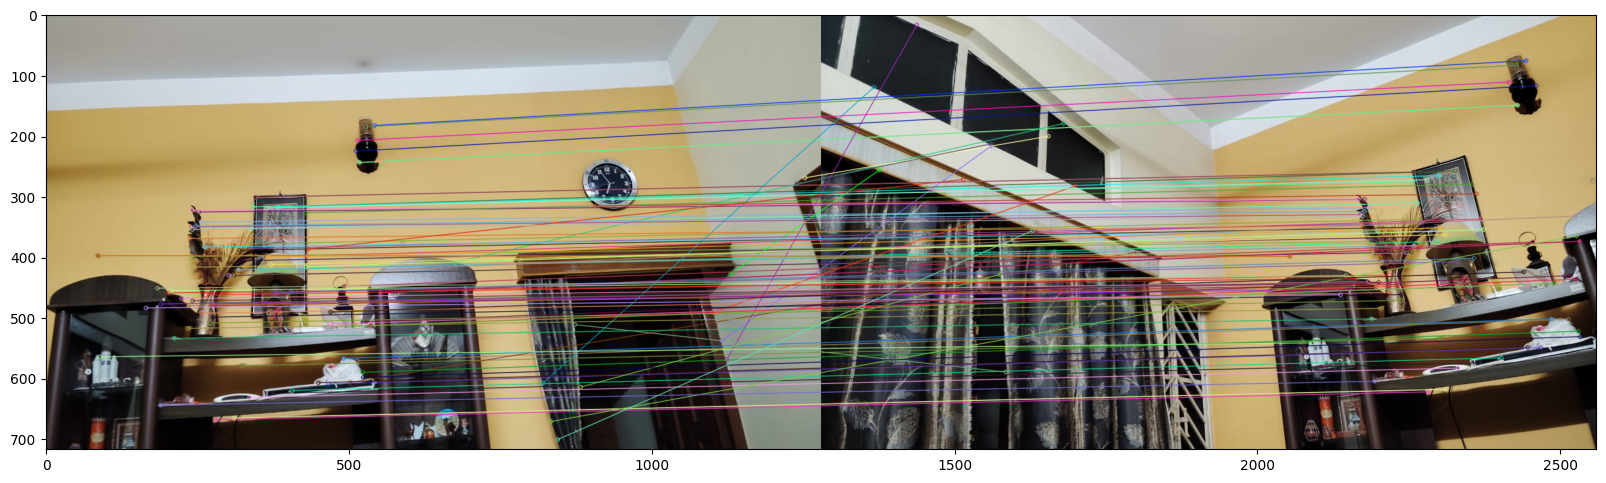

In [15]:
print("Drawing: {} matched features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(features_train_img, features_query_img, method=feature_extraction_algo)

    mapped_features_image = cv2.drawMatches(train_img,keypoints_train_img,query_img,keypoints_query_img,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(features_train_img, features_query_img, ratio=0.75, method=feature_extraction_algo)

    mapped_features_image_knn = cv2.drawMatches(train_img, keypoints_train_img, query_img, keypoints_query_img, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


plt.imshow(mapped_features_image)


Drawing: knn matched features Lines
Raw matches (knn): 1747


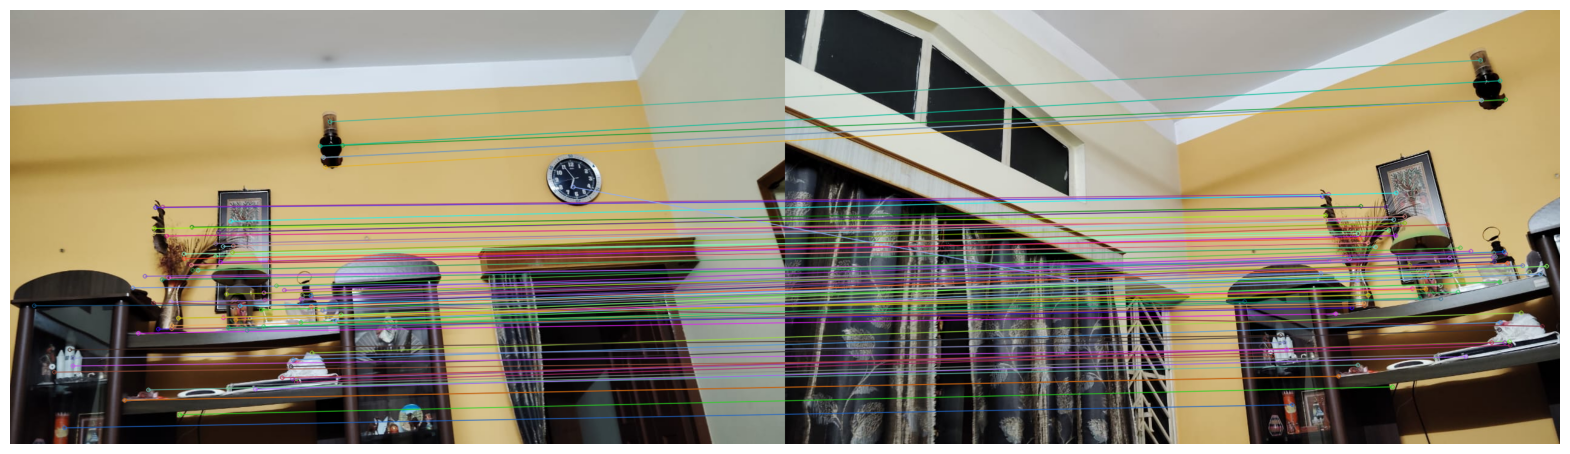

In [17]:
feature_to_match = 'knn'

print("Drawing: {} matched features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(features_train_img, features_query_img, method=feature_extraction_algo)

    mapped_features_image = cv2.drawMatches(train_img,keypoints_train_img,query_img,keypoints_query_img,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(features_train_img, features_query_img, ratio=0.75, method=feature_extraction_algo)

    mapped_features_image_knn = cv2.drawMatches(train_img, keypoints_train_img, query_img, keypoints_query_img, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


plt.imshow(mapped_features_image_knn)
plt.axis('off')

plt.show()

In [18]:
def homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh):
    keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
    keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])

    if len(matches) > 4:

        points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches])

        # Calculate the homography
        (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

In [19]:
M = homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh=4)

if M is None:
    print("Error!")

(matches, Homography_Matrix, status) = M

print(Homography_Matrix)

[[ 3.85101098e-01  1.94431588e-01  6.29172105e+02]
 [-3.28312441e-01  8.13946793e-01  8.58807556e+01]
 [-4.55009275e-04 -1.22404591e-05  1.00000000e+00]]


Width : 2560
Height:  717


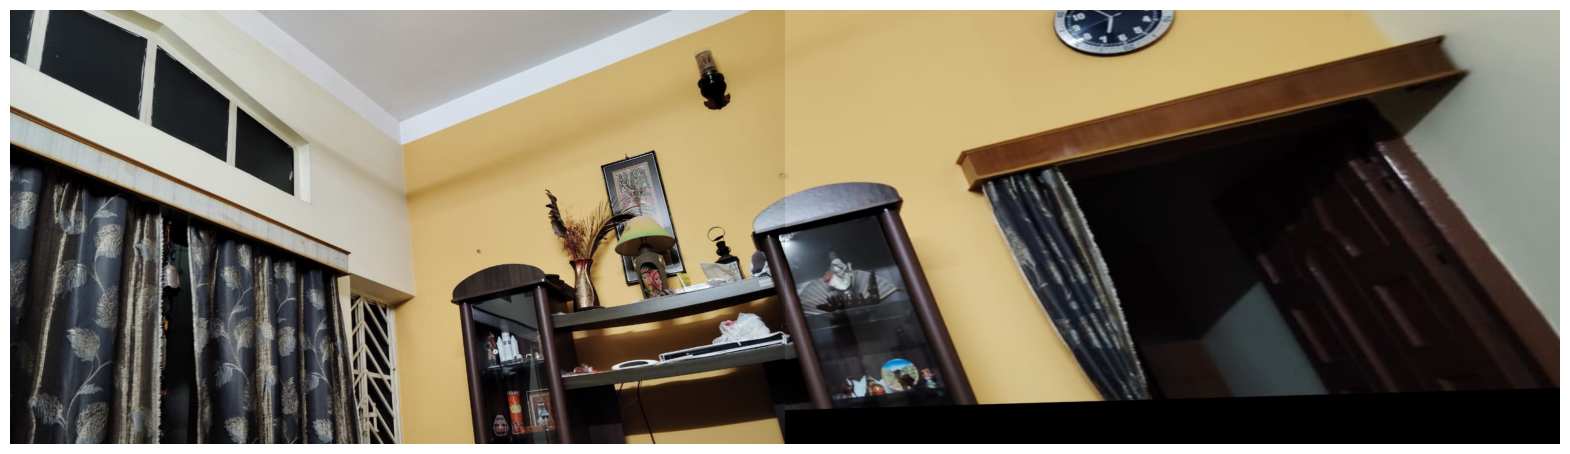

In [21]:
width = query_img.shape[1] + train_img.shape[1]
print("Width :", width)
height = max(query_img.shape[0], train_img.shape[0])
print("Height: ", height)

result = cv2.warpPerspective(train_img, Homography_Matrix,  (width, height))

result[0:query_img.shape[0], 0:query_img.shape[1]] = query_img

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)

imageio.imwrite("/content/result"+'.jpeg', result)

plt.show()